In [8]:
import warnings
warnings.filterwarnings('ignore')

In [25]:
from time import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import os

from collections import defaultdict
from itertools import izip

from sklearn import metrics
from sklearn.cluster import KMeans, AgglomerativeClustering, MiniBatchKMeans
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
import sklearn.manifold as sm


import pylab
%matplotlib inline
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

In [10]:
np.random.seed(42)

digits = load_digits()
data = scale(digits.data)
n_samples, n_features = data.shape
n_digits = len(np.unique(digits.target))
labels = digits.target
print "Loaded {} samples, {} features, {} digits. Labels: {} of shape {}".format(n_samples, n_features, n_digits, labels, labels.shape)

Loaded 1797 samples, 64 features, 10 digits. Labels: [0 1 2 ..., 8 9 8] of shape (1797,)


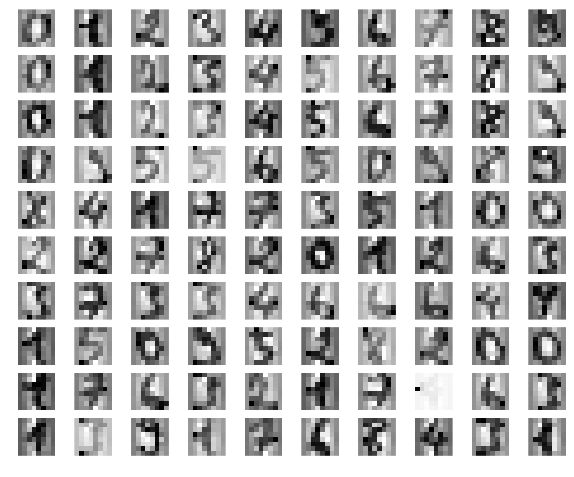

In [11]:
fig = plt.figure()
dim = 10

for i in xrange(dim * dim):
    a = fig.add_subplot(dim, dim, i + 1)
    plt.axis('off')
    imgplot = plt.imshow(np.reshape(data[i], (-1, 8)), cmap=plt.cm.binary, interpolation='none')

In [20]:
def save_data(labels, data, name):
    clusters = defaultdict(list)
    for l, img in izip(labels, data):
        clusters[l].append(img)

    for l in sorted(clusters.iterkeys()):
        dir_name = os.path.join('clusters', name)
        if not os.path.exists(dir_name):
            os.makedirs(dir_name)

        fig = plt.figure()
        dim = 2
        for idx, im in enumerate(clusters[l]):
            if idx > 15:
                break
            path = os.path.join(dir_name, str(l) + '_' + str(idx) + '.png')
            imgplot = plt.imshow(np.reshape(im, (-1, 8)), cmap=plt.cm.binary)
            fig.savefig(path)
            
        plt.close(fig)

In [21]:
save_files = True

sample_size = 300
def bench_estimator(estimator, name, data):
    t0 = time()
    estimator.fit(data)
    print('% 13s   %.2fs   %.3f   %.3f   %.3f   %.3f   %.3f    %.3f'
          % (name, (time() - t0),
             metrics.homogeneity_score(labels, estimator.labels_),
             metrics.completeness_score(labels, estimator.labels_),
             metrics.v_measure_score(labels, estimator.labels_),
             metrics.adjusted_rand_score(labels, estimator.labels_),
             metrics.adjusted_mutual_info_score(labels,  estimator.labels_),
             metrics.silhouette_score(data, estimator.labels_,
                                      metric='euclidean',
                                      sample_size=sample_size)))
    
    if save_files:
        save_data(estimator.labels_, data, name)

bench_estimator(KMeans(init='k-means++', n_clusters=n_digits, n_init=10), name="k-means++", data=data)
bench_estimator(KMeans(init='random', n_clusters=n_digits, n_init=10), name="random", data=data)
bench_estimator(AgglomerativeClustering(linkage='complete', n_clusters=n_digits), name="agglomerative", data=data)
bench_estimator(MiniBatchKMeans(n_clusters=n_digits, n_init=10), name="minibatch", data=data)

    k-means++   0.39s   0.608   0.657   0.632   0.478   0.604    0.123
       random   0.35s   0.614   0.661   0.637   0.485   0.610    0.117
agglomerative   3.65s   0.017   0.249   0.032   0.000   0.009    0.356
    minibatch   0.05s   0.606   0.632   0.619   0.474   0.602    0.097
    PCA-based   0.02s   0.673   0.715   0.693   0.567   0.670    0.133
_______________________________________________________________________________


In [33]:
def plot_dataset(data, x, y, margin=50, frame=1000., imsize=8):
    x1 = (x - x.min()) * (frame / (x.max() - x.min())) + margin
    y1 = (y - y.min()) * (frame / (y.max() - y.min())) + margin
    image = np.zeros((x1.max() + margin + imsize, y1.max() + margin + imsize)) + 255
    print "Image size is %dx%d" % image.shape
    for k in xrange(data.shape[0]):
        image[x1[k]:x1[k]+8, y1[k]:y1[k]+8] = np.reshape(data[k], (-1, 8)) * 255
    plt.figure(figsize=(20, 20))
    plt.imshow(image, cmap=plt.cm.binary, interpolation='none')
    plt.axis("off")
    plt.show()

Image size is 1108x1108


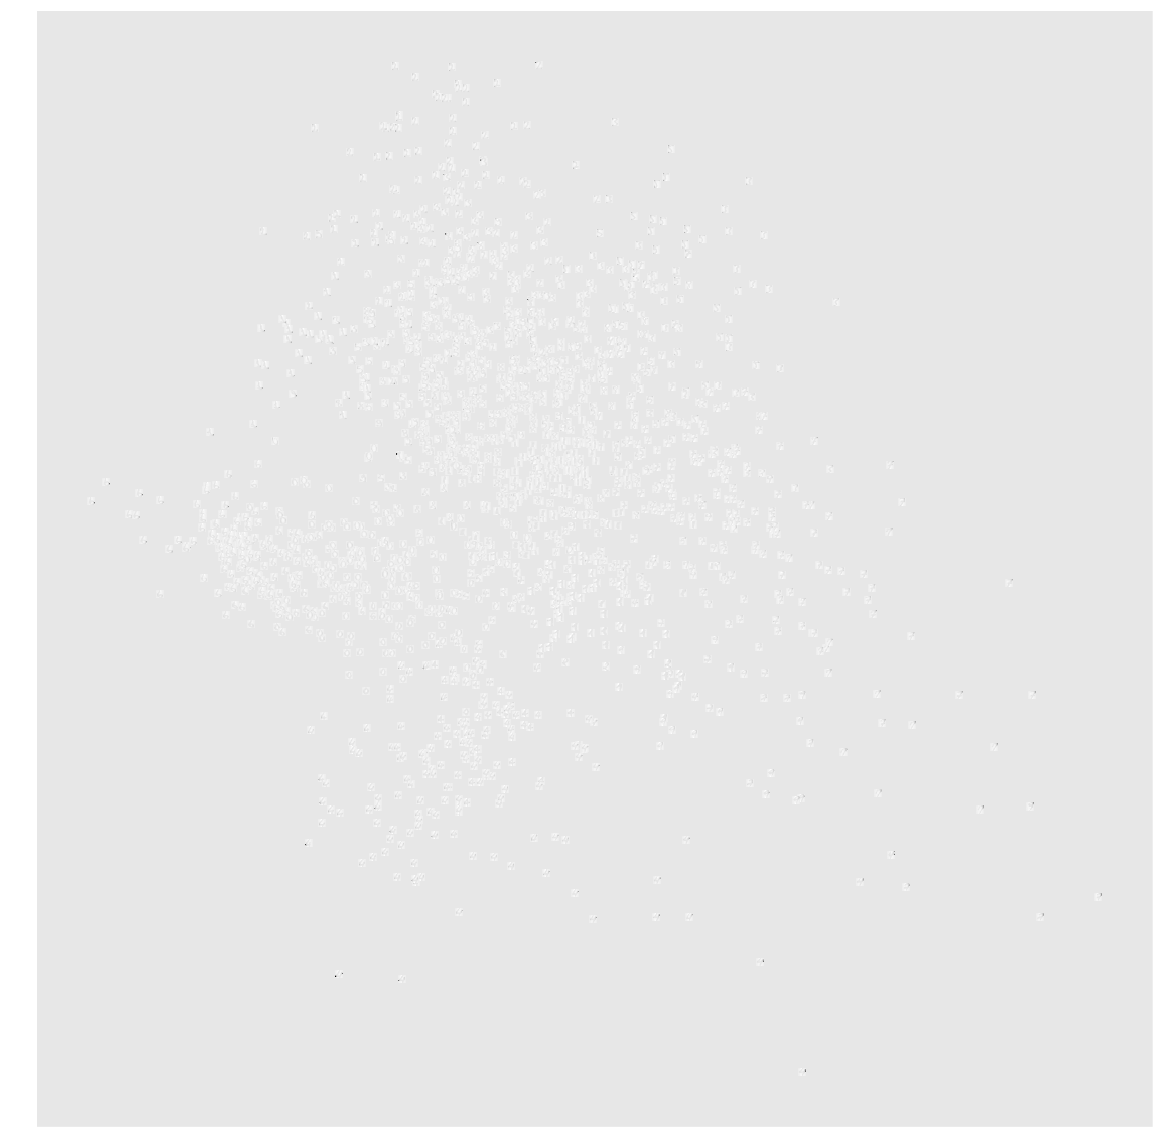

In [34]:
reduced_data = PCA(n_components=2).fit_transform(data)
plot_dataset(data, reduced_data[:, 0], reduced_data[:, 1])

[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 1000 / 1797
[t-SNE] Computed conditional probabilities for sample 1797 / 1797
[t-SNE] Mean sigma: 2.294230
[t-SNE] Error after 83 iterations with early exaggeration: 15.599882
[t-SNE] Error after 191 iterations: 1.068178
Image size is 1108x1108


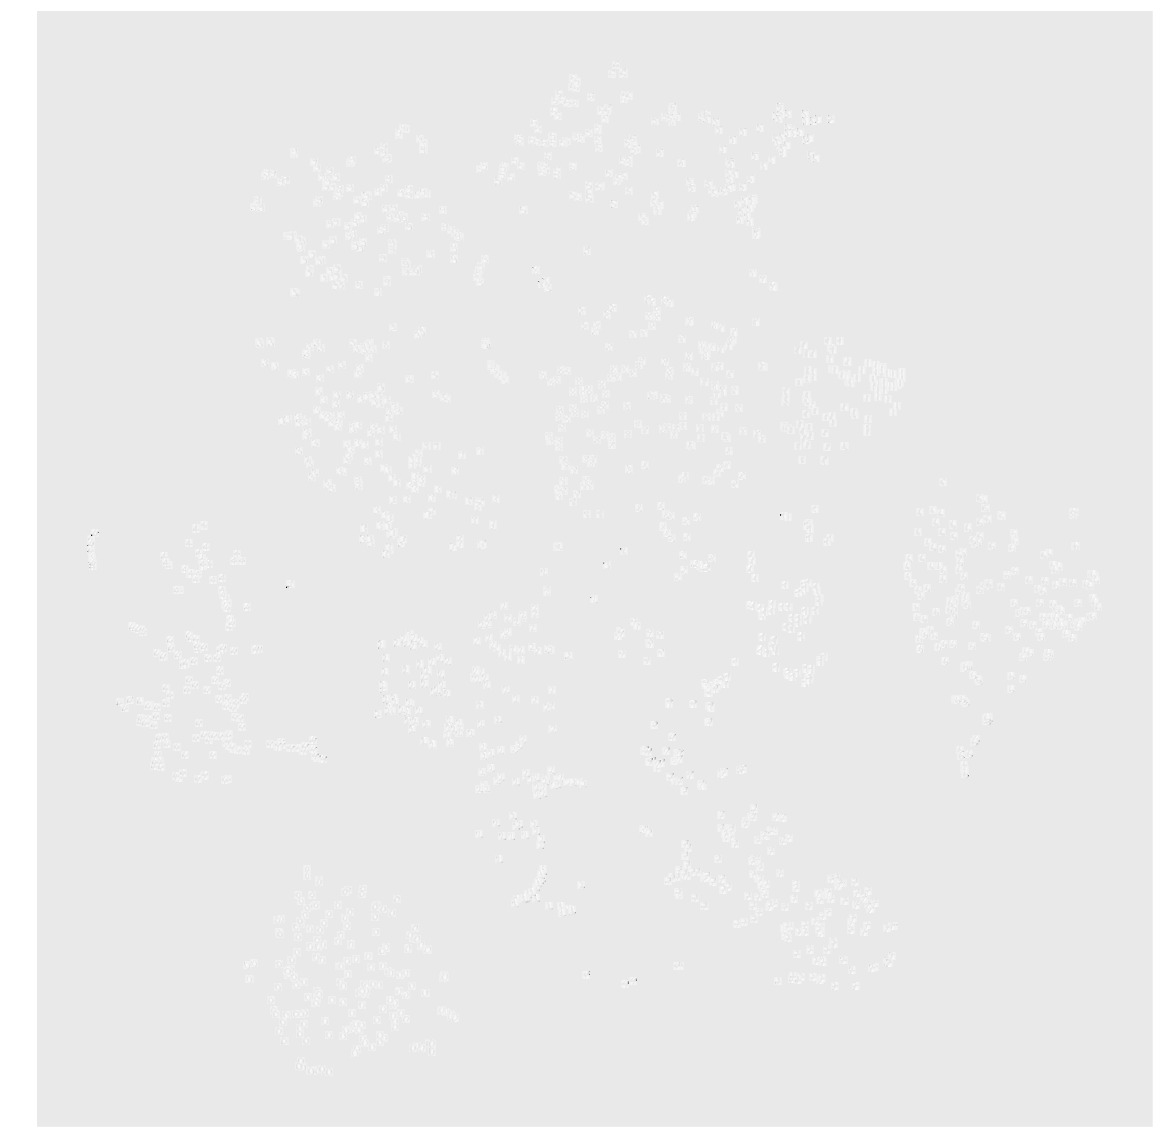

In [26]:
# reduced_data = PCA(n_components=2).fit_transform(data)

tsne = sm.TSNE(n_components=2, perplexity=30.0, verbose=1, n_iter=1000)
reduced_data = tsne.fit_transform(np.asfarray(data, dtype='float'))
plot_dataset(data, reduced_data[:, 0], reduced_data[:, 1])